In [1]:
!pip install tenseal

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

#Read Image from path and convert into grayscale if it is not
def read_image_to_array(image_path):
    image = Image.open(image_path).convert('L')
    return np.array(image)

#Show image
def display_image(image_array):
    plt.imshow(Image.fromarray(image_array), cmap="gray")
    plt.title('Pillow Image')
    plt.show()

In [3]:
import tenseal as ts

# Setup TenSEAL context
context = ts.context(
            ts.SCHEME_TYPE.CKKS,
            poly_modulus_degree=8192,
            coeff_mod_bit_sizes=[60, 40, 40, 60]
          )

context.generate_galois_keys()
context.global_scale = 2**40

def encryptImage(img,size):
  res = []

  #Get ROI of each pixel, flatten it, encrypt the resulting vectors, and save the value into a matrix
  for i in range(0,img.shape[0]-size+1):
    col = []
    for j in range(0,img.shape[1]-size+1):
        ROI = np.array(img[i:i+size,j:j+size])
        flatROI = ROI.flatten()
        enc = ts.ckks_vector(context, flatROI)
        col.append(enc)
    res.append(col)
  return np.array(res)

def decryptImage(img):
  res = []

  #Decrypt and decode each element of a matrix to retrieve convoluted image
  for col in img:
    resTemp = []
    for item in col:
      resTemp.append(item.decrypt())
    res.append(resTemp)
  return res

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from skimage import color
from skimage import io

def convolution(img, kernel):
    #Pad image with 0
    heightKernel = int(np.floor(len(kernel)/2))
    widthKernel = int(np.floor(len(kernel[0])/2))
    padImg = pad_array_with_zeros(image_array, heightKernel, heightKernel, widthKernel, widthKernel)

    #Encrypt image
    encImg = encryptImage(padImg, kernel.shape[0])

    #Flatten kernel
    flatKernel = kernel.flatten()

    #Convolve encrypted image
    res = encImg.copy()
    for i in range(res.shape[0]):
        for j in range(res.shape[1]):
          res[i,j] = res[i,j].dot(flatKernel)

    #Decrypt convolved image
    decImg = decryptImage(res)

    final = normalizeImage(decImg)
    return final

#Pad matrix with zeros
def pad_array_with_zeros(input_array, top, bottom, left, right):
    padded_array = np.pad(input_array, ((top, bottom), (left, right)), mode='constant', constant_values=0)
    return padded_array

#Normalize array so it ranges between 0 and 255
def normalizeImage(img):
    img = np.array(img)
    res = img.reshape(img.shape[0],img.shape[1])
    clipped_image = np.clip(res, 0, 255).astype(np.uint8)
    return clipped_image

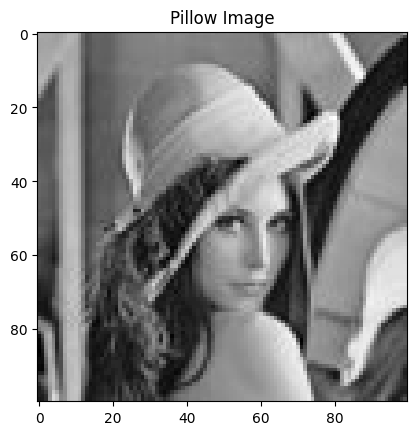

In [5]:
# Specify the path to image file
image_path = '/content/lenars.jpg'

# Read the image and convert it into a NumPy array
image_array = read_image_to_array(image_path)

display_image(image_array)

In [6]:
import time
start_time = time.time()
kernel = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]])

final = convolution(image_array, kernel)
end_time = time.time()

In [7]:
elapsed_time = end_time - start_time

print(f"Time needed: {elapsed_time} seconds")

Time needed: 268.8466386795044 seconds


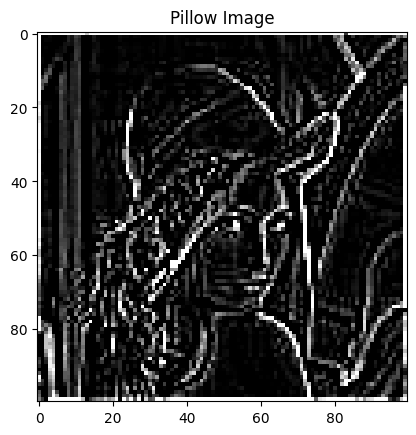

In [8]:
display_image(final)

In [9]:
cv2.imwrite('lenaMod1.jpg', final)

True

In [10]:
import cv2
import numpy as np

def psnr(img1, img2):
    # Convert images to float32
    img1 = img1.astype(np.float32)
    img2 = img2.astype(np.float32)

    # Calculate MSE
    mse = np.mean((img1 - img2) ** 2)

    # Calculate PSNR
    max_pixel_value = 255.0
    psnr_value = 20 * np.log10((max_pixel_value) / np.sqrt(mse))

    return psnr_value

image1 = read_image_to_array('/content/lenakonv.jpg')
image2 = final

# # Calculate PSNR
psnr_value = psnr(image1, image2)

print(f'PSNR: {psnr_value} dB')

PSNR: 31.84207350753106 dB
